In [11]:
!pip install xgboost tensorflow

In [12]:
import numpy as np
import pandas as pd

# фиксируем случайность
np.random.seed(42)

# размер датасета
n = 10000

# координаты посадки
pickup_lat = np.random.uniform(40.6, 40.8, n)
pickup_lon = np.random.uniform(-74.05, -73.75, n)

# координаты высадки
drop_lat = pickup_lat + np.random.normal(0, 0.02, n)
drop_lon = pickup_lon + np.random.normal(0, 0.02, n)

# расстояние (приближённое)
distance = np.sqrt(
    (pickup_lat - drop_lat) ** 2 +
    (pickup_lon - drop_lon) ** 2
) * 111

# время и пассажиры
hour = np.random.randint(0, 24, n)
passengers = np.random.randint(1, 5, n)

# стоимость поездки
fare = (
    3
    + distance * 2.5
    + hour * 0.2
    + passengers * 0.5
    + np.random.normal(0, 2, n)
)

# временные метки
dates = pd.date_range(
    start="2024-01-01",
    periods=n,
    freq="min"
)

# собираем таблицу
df = pd.DataFrame({
    "pickup_datetime": dates,
    "pickup_latitude": pickup_lat,
    "pickup_longitude": pickup_lon,
    "dropoff_latitude": drop_lat,
    "dropoff_longitude": drop_lon,
    "passenger_count": passengers,
    "fare_amount": fare
})

# вывод
df.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
0,2024-01-01 00:00:00,40.674908,-73.937908,40.658832,-73.955446,2,13.067694
1,2024-01-01 00:01:00,40.790143,-73.950126,40.801863,-73.958937,4,11.682631
2,2024-01-01 00:02:00,40.746399,-73.997154,40.772524,-74.020909,4,17.299450
3,2024-01-01 00:03:00,40.719732,-73.867820,40.695193,-73.852479,1,12.722207
4,2024-01-01 00:04:00,40.631204,-73.907013,40.665450,-73.918731,4,18.118372


In [13]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pickup_datetime    10000 non-null  datetime64[ns]
 1   pickup_latitude    10000 non-null  float64       
 2   pickup_longitude   10000 non-null  float64       
 3   dropoff_latitude   10000 non-null  float64       
 4   dropoff_longitude  10000 non-null  float64       
 5   passenger_count    10000 non-null  int64         
 6   fare_amount        10000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 547.0 KB


,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fare_amount
count,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2024-01-04 11:19:30,40.698832,-73.898641,40.698897,-73.898951,2.507000,13.550639
min,2024-01-01 00:00:00,40.600002,-74.049953,40.539931,-74.104102,1.000000,0.114375
25%,2024-01-02 17:39:45,40.649266,-73.973816,40.649584,-73.973880,2.000000,10.396023
50%,2024-01-04 11:19:30,40.698506,-73.898231,40.697951,-73.898581,2.000000,13.338620
75%,2024-01-06 04:59:15,40.748001,-73.823056,40.748515,-73.824072,4.000000,16.382882
max,2024-01-07 22:39:00,40.799944,-73.750023,40.867794,-73.698638,4.000000,36.638434
std,NaN,0.057526,0.086788,0.060630,0.089128,1.123155,4.374158


In [14]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df["hour"] = df["pickup_datetime"].dt.hour
df["day"] = df["pickup_datetime"].dt.dayofweek

In [15]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1))*np.cos(np.radians(lat2))*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

df["distance"] = haversine(
    df["pickup_latitude"],
    df["pickup_longitude"],
    df["dropoff_latitude"],
    df["dropoff_longitude"]
)

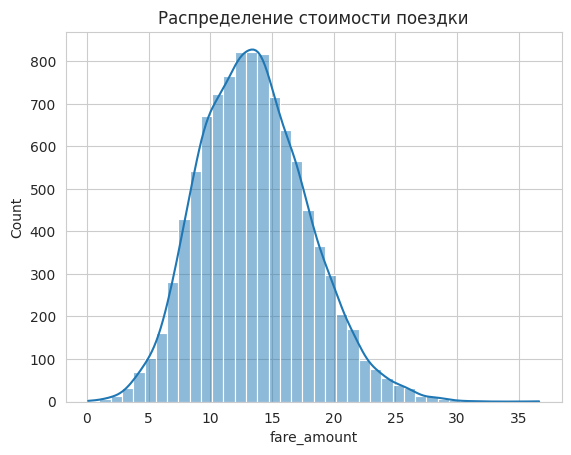

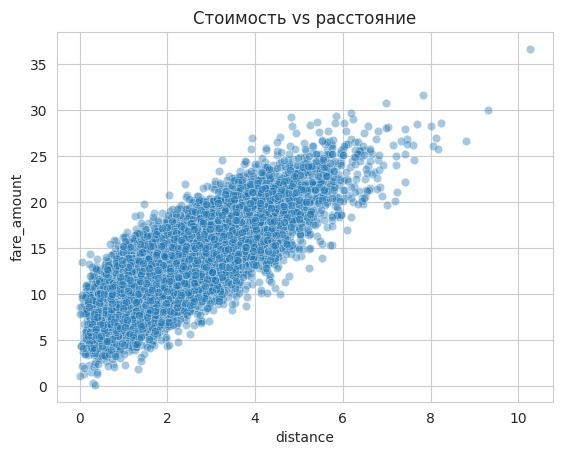

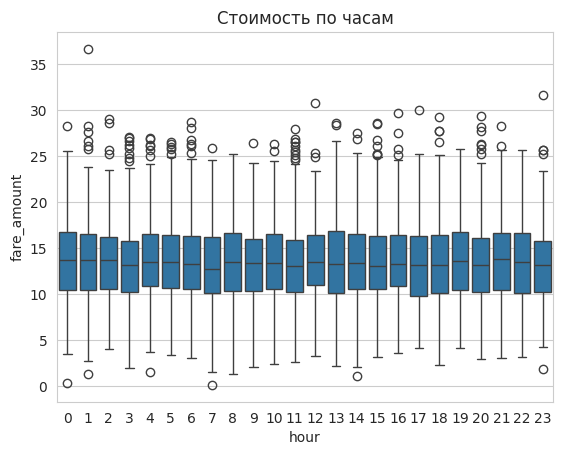

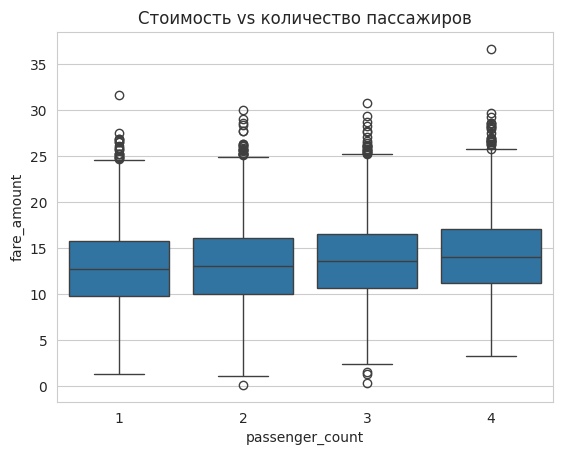

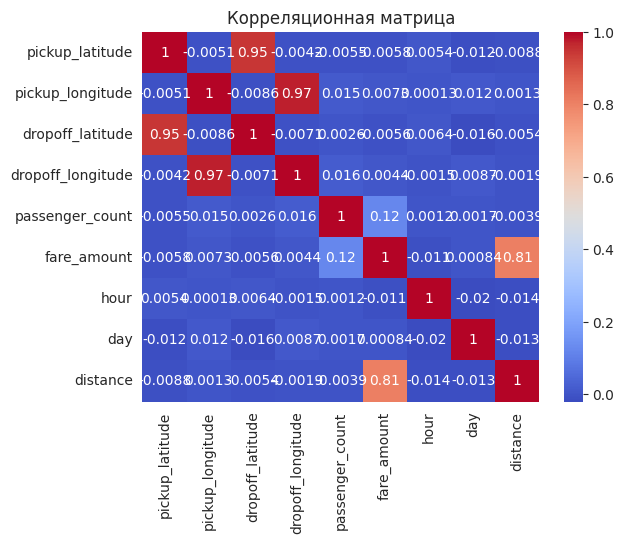

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- распределение стоимости
plt.figure()
sns.histplot(df["fare_amount"], bins=40, kde=True)
plt.title("Распределение стоимости поездки")
plt.show()

# --- расстояние vs цена
plt.figure()
sns.scatterplot(x=df["distance"], y=df["fare_amount"], alpha=0.4)
plt.title("Стоимость vs расстояние")
plt.show()

# --- влияние часа
plt.figure()
sns.boxplot(x=df["hour"], y=df["fare_amount"])
plt.title("Стоимость по часам")
plt.show()

# --- пассажиры
plt.figure()
sns.boxplot(x=df["passenger_count"], y=df["fare_amount"])
plt.title("Стоимость vs количество пассажиров")
plt.show()

# --- корреляции
plt.figure()
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.show()

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ["distance", "hour", "day", "passenger_count"]

X = df[features]
y = df["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

In [32]:
trip = pd.DataFrame({
    "distance": [5],
    "hour": [14],
    "day": [2],
    "passenger_count": [1]
})

trip = trip[features]  # гарантируем порядок колонок

trip_scaled = scaler.transform(trip)

prediction = best_model.predict(trip_scaled)

print(" Цена:", prediction[0])

 Цена: 19.560597443364045


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(model, name):
    pred = model.predict(X_test)

    print("\n", name)
    print("MAE:", mean_absolute_error(y_test, pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
    print("R2:", r2_score(y_test, pred))

In [20]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

evaluate(lr, "Linear Regression")


 Linear Regression
MAE: 1.9827104539677518
RMSE: 2.489917357168119
R2: 0.6695154359759228


In [21]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=8)
tree.fit(X_train, y_train)

evaluate(tree, "Decision Tree")


 Decision Tree
MAE: 2.0984140689127124
RMSE: 2.6627144577128674
R2: 0.6220533440658738


In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

evaluate(rf, "Random Forest")


 Random Forest
MAE: 2.1184455009196563
RMSE: 2.67680257479752
R2: 0.6180434191301489


In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

evaluate(xgb, "XGBoost")


 XGBoost
MAE: 2.121824526924871
RMSE: 2.6826957538016516
R2: 0.6163597564439636


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(32, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

pred = model.predict(X_test)

print("\nNeural Network")
print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2:", r2_score(y_test, pred))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Neural Network
MAE: 1.9938761956046391
RMSE: 2.506342589402246
R2: 0.6651408409089054


In [25]:
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [100, 200],
    "max_depth": [6, 10]
}

grid = GridSearchCV(RandomForestRegressor(), params, cv=3)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

evaluate(best_model, "Optimized RF")


 Optimized RF
MAE: 1.987292905725224
RMSE: 2.5004580655759834
R2: 0.6667113951515188


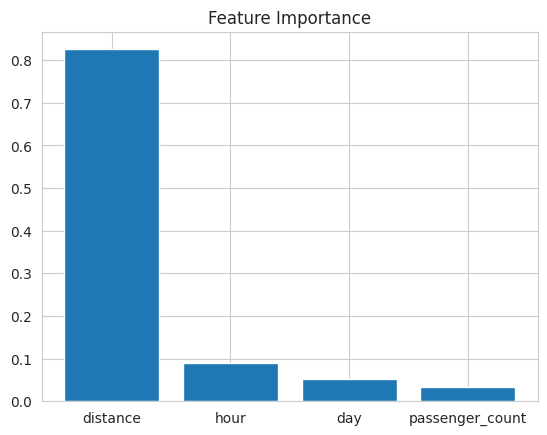

In [26]:
import matplotlib.pyplot as plt

importance = rf.feature_importances_

plt.bar(features, importance)
plt.title("Feature Importance")
plt.show()

In [27]:
def predict_trip():
    print("\n=== Предсказание стоимости поездки ===")

    distance = float(input("Введите расстояние (км): "))
    hour = int(input("Введите час поездки (0-23): "))
    day = int(input("Введите день недели (0=Пн ... 6=Вс): "))
    passengers = int(input("Введите количество пассажиров: "))

    trip = [[distance, hour, day, passengers]]
    trip_scaled = scaler.transform(trip)

    price = best_model.predict(trip_scaled)

    print("\n Предсказанная стоимость:", round(price[0], 2))


predict_trip()


=== Предсказание стоимости поездки ===
Введите расстояние (км): 1
Введите час поездки (0-23): 2
Введите день недели (0=Пн ... 6=Вс): 2
Введите количество пассажиров: 1

 Предсказанная стоимость: 9.44


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [28]:
import pandas as pd

trip = pd.DataFrame([{
    "distance": 5,
    "hour": 14,
    "day": 2,
    "passenger_count": 1
}])

trip_scaled = scaler.transform(trip)

prediction = best_model.predict(trip_scaled)

print(" Предсказанная цена:", prediction[0])

 Предсказанная цена: 19.560597443364045


In [29]:
import joblib

joblib.dump(best_model, "taxi_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(" Модель сохранена")

 Модель сохранена


In [30]:
model = joblib.load("taxi_model.pkl")
scaler = joblib.load("scaler.pkl")

In [35]:
predict_trip()


=== Предсказание стоимости поездки ===
Введите расстояние (км): 2
Введите час поездки (0-23): 3
Введите день недели (0=Пн ... 6=Вс): 2
Введите количество пассажиров: 2

 Предсказанная стоимость: 11.95
